In [6]:
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import numpy as np
import datetime as dt

### This notebook will create plots for naturalized streamflow, precipitation, and temperatures across the UCRB

In [7]:
# import UCRB precipitation
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [32]:
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '../data/precipdata/PRISM/PRISM_ppt_stable_4km/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_ds = prism_4km_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_ds = prism_4km_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_ds = prism_4km_ds.sortby('month')
       prism_4km_ds = prism_4km_ds.sel(month=slice('1981-01-01', '2022-09-01'))

In [38]:
# Download historic PRISM precipitation from 4km product 
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       outpath = '/storage/dlhogan/sos/data/PRISM_ppt/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_historic_ds = xr.concat(prism_list, dim='band')
       prism_4km_historic_ds = prism_4km_historic_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_historic_ds = prism_4km_historic_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_historic_ds = prism_4km_historic_ds.sortby('month')
       prism_4km_all_ds = xr.concat([prism_4km_historic_ds, prism_4km_ds], dim='month', join='override')
       prism_4km_all_ds.to_netcdf('../data/precipdata/prism_4km_ucrb.nc')
else:
       prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
       prism_4km_all_ds = prism_4km_all_ds.rename({'__xarray_dataarray_variable__':'ppt'})

In [39]:
if not os.path.exists('../data/etdata/prism_tmean_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '/storage/dlhogan/sos/data/PRISM/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 39)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_tmean_ds = xr.concat(prism_list, dim='band')
       prism_4km_tmean_ds = prism_4km_tmean_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_tmean_ds = prism_4km_tmean_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_tmean_ds = prism_4km_tmean_ds.sortby('month')
       prism_4km_tmean_ds = prism_4km_tmean_ds.sel(month=slice('1895-01-01', '2022-09-01'))

       prism_4km_tmean_ds.to_netcdf('../data/etdata/prism_tmean_4km_ucrb.nc')
else:
       prism_4km_tmean_ds = xr.open_dataset('../data/etdata/prism_tmean_4km_ucrb.nc')

# Import naturalized streamflow

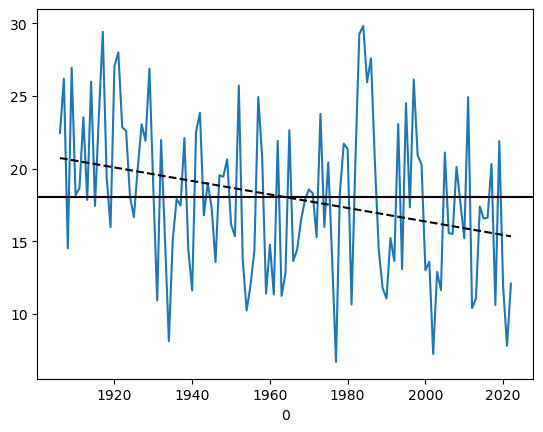

In [40]:
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()
slope1, intercept1, _,_,_ = stats.linregress(ucrb_naturalized_streamflow.index,ucrb_naturalized_streamflow['annual_flow_km3'].values)
ucrb_naturalized_streamflow['annual_flow_km3'].plot()
plt.plot(ucrb_naturalized_streamflow.index , slope1*ucrb_naturalized_streamflow.index + intercept1, ls='--',color='k')
plt.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='k')

In [41]:
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'ppt':'p_km3'})

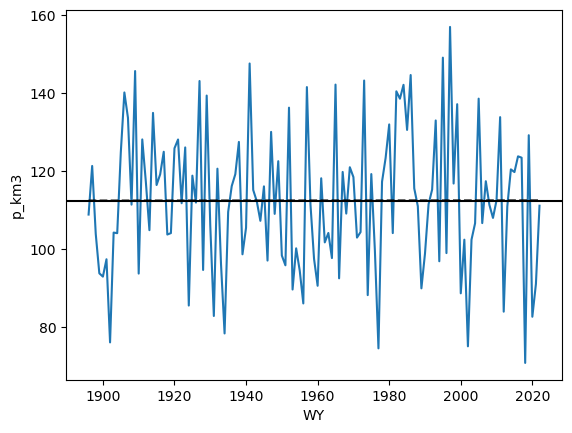

In [42]:
slope2, intercept2, _,_,_ = stats.linregress(annual_p_km3.WY,annual_p_km3['p_km3'].values)
annual_p_km3['p_km3'].plot()
plt.plot(annual_p_km3.WY , slope2*annual_p_km3.WY + intercept2, ls='--',color='k')
plt.axhline(annual_p_km3['p_km3'].mean(), color='k')

In [43]:
t_mean = prism_4km_tmean_ds.where(prism_4km_tmean_ds>-100).mean(dim=['x','y'])
t_mean['WY'] = t_mean.month.dt.year.where(t_mean.month.dt.month<10, t_mean.month.dt.year+1)
annual_t_mean = t_mean.groupby('WY').mean()
annual_t_mean = annual_t_mean.rename({'__xarray_dataarray_variable__':'t_mean'})
annual_t_mean = annual_t_mean.sel(WY=slice(1896,2022))


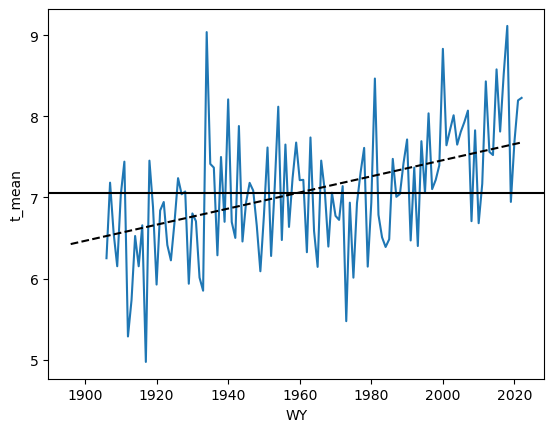

In [44]:
slope3, intercept3, _,_,_ = stats.linregress(annual_t_mean.WY,annual_t_mean['t_mean'].values)
annual_t_mean['t_mean'].sel(WY=slice(1906,2022)).plot()
plt.plot(annual_t_mean.WY , slope3*annual_t_mean.WY + intercept3, ls='--',color='k')
plt.axhline(annual_t_mean['t_mean'].mean(), color='k')

# Plot Precipitation, Streamflow and Temperature all together

In [45]:
drought_1930s = pd.date_range('1932-09-01','1936-08-31', freq='1M')
drought_1970s = pd.date_range('1976-09-01','1981-08-31',freq='1M')
drought_1980s = pd.date_range('1988-09-01','1993-08-31',freq='1M')
drought_2000s = pd.date_range('2000-09-01','2005-08-31',freq='1M')
drought_2010s = pd.date_range('2017-09-01','2022-08-31',freq='1M')
all_dates = pd.date_range('1895-10-01','2022-10-01', freq='1Y')

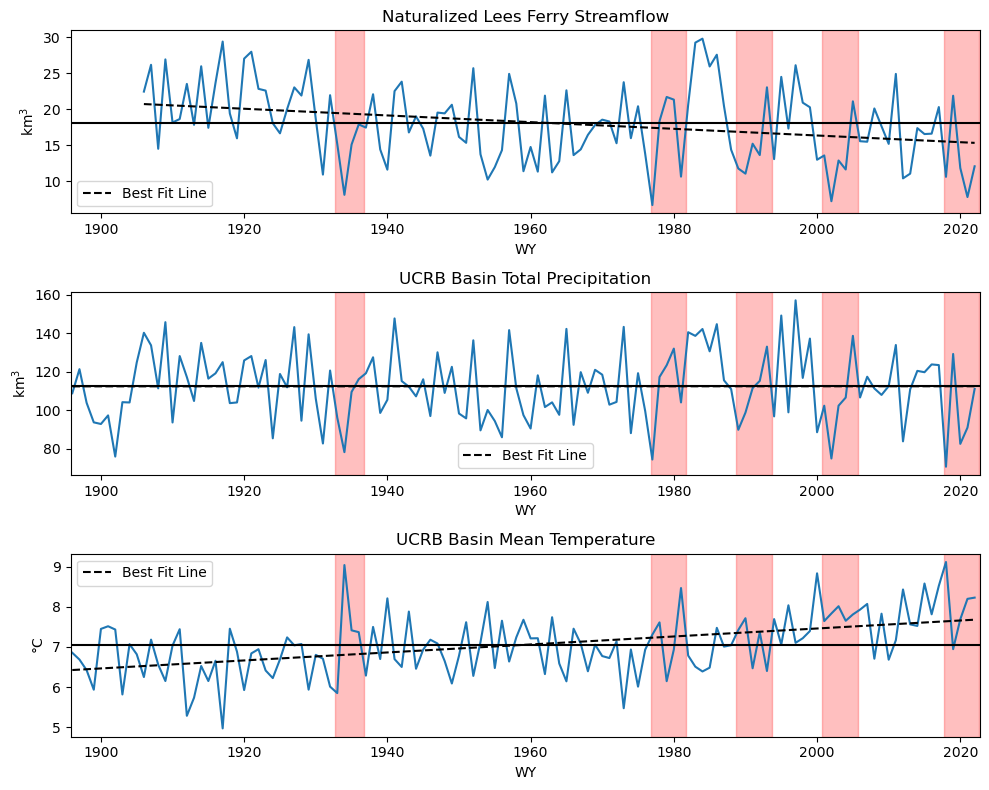

In [46]:
fig, axs = plt.subplots(nrows=3, figsize=(10,8), tight_layout=True)

ax = axs[0]
ax.plot(all_dates[10:] , ucrb_naturalized_streamflow['annual_flow_km3'])
ax.plot(all_dates[10:] , slope1*ucrb_naturalized_streamflow.index + intercept1, ls='--',color='k', label='Best Fit Line')
ax.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='k')
ax.set_ylabel('km$^3$')
ax.set_title('Naturalized Lees Ferry Streamflow')
ax.set_xlim()

ax = axs[1]
ax.plot(all_dates,annual_p_km3['p_km3'].values)
ax.plot(all_dates , slope2*annual_p_km3.WY + intercept2, ls='--',color='k', label='Best Fit Line')
ax.axhline(annual_p_km3['p_km3'].mean(), color='k')
ax.set_ylabel('km$^3$')
ax.set_title('UCRB Basin Total Precipitation')

ax = axs[2]
ax.plot(all_dates,annual_t_mean['t_mean'].values)
ax.plot(all_dates , slope3*annual_t_mean.WY + intercept3, ls='--',color='k', label='Best Fit Line')
ax.axhline(annual_t_mean['t_mean'].mean(), color='k')
ax.set_ylabel('$\degree$C')
ax.set_title('UCRB Basin Mean Temperature')
for ax in axs:
    for drought in [drought_1930s,drought_1970s,drought_1980s,drought_2000s,drought_2010s]:
        ax.axvspan(drought[0],drought[-1],color='red',alpha=0.25)
        ax.legend()
        ax.set_xlabel('WY')
        ax.set_xlim(dt.date(1895,10,1),dt.date(2022,10,1))

### Let's change to focusing on our HCDN basins

Pull in the HCDN basins as a geodataframe

In [417]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
hcdn_basins.loc['09107000','basin_area'] = 330482483

In [426]:
hcdn_basins

,name,basin_area,snotel_count,geometry
gage,,,,
09034900,"BOBTAIL CREEK NEAR JONES PASS, CO.",1.358455e+07,2,"MULTIPOLYGON (((424424.38098 4401584.84068, 42..."
09035900,"SOUTH FORK OF WILLIAMS FORK NEAR LEAL, CO.",7.256992e+07,2,"MULTIPOLYGON (((420669.68916 4394956.26406, 42..."
09047700,"KEYSTONE GULCH NEAR DILLON, CO.",2.355506e+07,3,"MULTIPOLYGON (((421429.47179 4379838.75203, 42..."
09065500,"GORE CREEK AT UPPER STATION, NEAR MINTURN, CO.",3.775570e+07,3,"MULTIPOLYGON (((390672.90608 4388220.20206, 39..."
09066000,"BLACK GORE CREEK NEAR MINTURN, CO.",3.239292e+07,3,"MULTIPOLYGON (((391595.48742 4382425.40303, 39..."
09066200,"BOOTH CREEK NEAR MINTURN, CO.",1.608865e+07,3,"MULTIPOLYGON (((388913.65312 4391968.06997, 38..."
09066300,"MIDDLE CREEK NEAR MINTURN, CO.",1.551507e+07,2,"MULTIPOLYGON (((384746.60139 4392300.37202, 38..."
09081600,"CRYSTAL RIVER AB AVALANCHE C, NEAR REDSTONE, CO.",4.329286e+08,3,"MULTIPOLYGON (((294794.29755 4343640.79257, 29..."
09107000,"TAYLOR RIVER AT TAYLOR PARK, CO.",3.304825e+08,7,"MULTIPOLYGON (((348635.23618 4322926.93778, 34..."


Create a data array to add in the basin area to our dataset

In [418]:
area_da = hcdn_basins.basin_area.to_xarray()
area_da = area_da.rename({'gage':'site_no'})

Create a data array to add in centroid lat and long to our dataset

In [390]:
centroid_da = hcdn_basins.geometry.centroid.to_xarray()
centroid_da

/tmp/ipykernel_10352/307785078.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_da = hcdn_basins.geometry.centroid.to_xarray()


<xarray.DataArray (gage: 29)>
array([<shapely.geometry.point.Point object at 0x7f1d10499610>,
       <shapely.geometry.point.Point object at 0x7f1d10499a00>,
       <shapely.geometry.point.Point object at 0x7f1d10499400>,
       <shapely.geometry.point.Point object at 0x7f1d104b2460>,
       <shapely.geometry.point.Point object at 0x7f1d104b2eb0>,
       <shapely.geometry.point.Point object at 0x7f1d104b2b20>,
       <shapely.geometry.point.Point object at 0x7f1d104b2fa0>,
       <shapely.geometry.point.Point object at 0x7f1d104b2d60>,
       <shapely.geometry.point.Point object at 0x7f1d104b2df0>,
       <shapely.geometry.point.Point object at 0x7f1d104b2f70>,
       <shapely.geometry.point.Point object at 0x7f1d104b2e50>,
       <shapely.geometry.point.Point object at 0x7f1d104b2640>,
       <shapely.geometry.point.Point object at 0x7f1d1040a820>,
       <shapely.geometry.point.Point object at 0x7f1d1040a790>,
       <shapely.geometry.point.Point object at 0x7f1d1042ce80>,
       <shapely.geometry.point.Point object at 0x7f1d1042ceb0>,
       <shapely.geometry.point.Point object at 0x7f1d1042cf10>,
       <shapely.geometry.point.Point object at 0x7f1d1042cf40>,
       <shapely.geometry.point.Point object at 0x7f1d1042cfd0>,
       <shapely.geometry.point.Point object at 0x7f1d1043d0a0>,
       <shapely.geometry.point.Point object at 0x7f1d1043d3a0>,
       <shapely.geometry.point.Point object at 0x7f1d1043d370>,
       <shapely.geometry.point.Point object at 0x7f1d1043d310>,
       <shapely.geometry.point.Point object at 0x7f1d1043d2e0>,
       <shapely.geometry.point.Point object at 0x7f1d1043da60>,
       <shapely.geometry.point.Point object at 0x7f1d1043d130>,
       <shapely.geometry.point.Point object at 0x7f1d1043d190>,
       <shapely.geometry.point.Point object at 0x7f1d1043d1c0>,
       <shapely.geometry.point.Point object at 0x7f1d1043d5b0>],
      dtype=object)
Coordinates:
  * gage     (gage) object '09034900' '09035900' ... '09378170' '09378630'

Open the UCRB dem and derive basin mean elevations for each basin...

In [62]:
ucrb_dem = rxr.open_rasterio('../basin_characteristics/ucrb_dem_150m.tif')
basin_mean_elevations = {}
for gage in hcdn_basins.index:
    basin = hcdn_basins[hcdn_basins.index==gage]
    clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
    clipped_dem_ma = clipped_dem.where(clipped_dem>0)
    basin_mean_elevations[gage] = clipped_dem_ma.mean().values

Then add this to a data array to pull into our entire dataset

In [63]:
elevation_da = xr.Dataset(basin_mean_elevations).to_array()
elevation_da.name='elevation'
elevation_da = elevation_da.rename({'variable':'site_no'})

Add precipitation

In [419]:
# Pull in HCDN precip data
hcdn_prism_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt.nc')
hcdn_prism_seasonal_ppt = hcdn_prism_seasonal_ppt.sel(dim_1='ppt')
hcdn_prism_seasonal_ppt = hcdn_prism_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt','variable':'site_no'})

hcdn_prism_seasonal_ppt['year'] = hcdn_prism_seasonal_ppt.month.dt.year.where(hcdn_prism_seasonal_ppt.month.dt.month<10, hcdn_prism_seasonal_ppt.month.dt.year+1)
hcdn_prism_annual_ppt = hcdn_prism_seasonal_ppt.groupby('year').sum()

Do the same using the aspect tif file. 

In [420]:
ucrb_aspect = rxr.open_rasterio('../basin_characteristics/ucrb_aspect.tif')
basin_aspect_classification = {}
for gage in hcdn_basins.index:
    basin = hcdn_basins[hcdn_basins.index==gage]
    # Clip file to basin geometry
    clipped_aspect = ucrb_aspect.rio.clip(basin.geometry).squeeze()
    # Mask out values less than 0
    clipped_aspect_ma = clipped_aspect.where(clipped_aspect>=0)
    # Create omni-directional masks
    north = clipped_aspect_ma.where((clipped_aspect_ma>=270) | (clipped_aspect_ma<90))
    south = clipped_aspect_ma.where((clipped_aspect_ma>=90) & (clipped_aspect_ma<270))
    west = clipped_aspect_ma.where((clipped_aspect_ma>=225) & (clipped_aspect_ma<315))
    east = clipped_aspect_ma.where((clipped_aspect_ma>=45) & (clipped_aspect_ma<135))
    north_fraction = north.count()/clipped_aspect_ma.count()
    south_fraction = south.count()/clipped_aspect_ma.count()
    west_fraction = west.count()/clipped_aspect_ma.count()
    east_fraction = east.count()/clipped_aspect_ma.count()
    basin_aspect_classification[gage] = (float(north_fraction.values),float(south_fraction.values),
                                         float(west_fraction.values),float(east_fraction.values))

In [421]:
aspect_df = pd.DataFrame.from_dict(basin_aspect_classification).T
aspect_df = aspect_df.rename(columns={0:'north',1:'south',2:'west',3:'east'})
aspect_df['north'] = (aspect_df['north'] - aspect_df['north'].min())/(aspect_df['north'].max() - aspect_df['north'].min())
aspect_df['south'] = (aspect_df['south'] - aspect_df['south'].min())/(aspect_df['south'].max() - aspect_df['south'].min())
aspect_ds = aspect_df.to_xarray()
aspect_ds = aspect_ds.rename({'index':'site_no'})

Pull in our HCDN flow data and convert to mm per day units

In [422]:
# used for unit conversion
cubic_ft_to_m = 35.315
# Pull in streamflow data and merge in new datarrays
hcdn_streamflow_ds = xr.open_dataset('../data/streamflowdata/hcdn_q_data.nc')
hcdn_streamflow_ds['site_no'] = ['0'+str(site) for site in hcdn_streamflow_ds['site_no'].values]
hcdn_streamflow_ds = hcdn_streamflow_ds.merge(area_da)
hcdn_streamflow_ds = hcdn_streamflow_ds.merge(elevation_da)
hcdn_streamflow_ds = hcdn_streamflow_ds.merge(aspect_ds)
# Calculate flow rates in terms of basin-normalized mm/day from cubic feet per second
hcdn_streamflow_ds['q_mm_day'] = hcdn_streamflow_ds['00060_Mean'] * 1000 /hcdn_streamflow_ds.basin_area

# Derive summer only mean flows 
hcdn_q_summer_ds = hcdn_streamflow_ds.where(hcdn_streamflow_ds.date.dt.month.isin([7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_summer_ds = hcdn_q_summer_ds.sortby('date')
hcdn_q_summer_ds = hcdn_q_summer_ds.where(hcdn_q_summer_ds['q_mm_day']>0)
hcdn_q_summer_ds = hcdn_q_summer_ds.rename({'q_mm_day':'q_mm_day_summer'})
hcdn_q_summer_mean_ds = hcdn_q_summer_ds.groupby('date.year').mean()
# Derive the mean Spring + Summer flow for AMJJAS
hcdn_q_spring_summer_ds = hcdn_streamflow_ds.where(hcdn_streamflow_ds.date.dt.month.isin([4,5,6,7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_spring_summer_ds = hcdn_q_spring_summer_ds.sortby('date')
hcdn_q_spring_summer_ds = hcdn_q_spring_summer_ds.where(hcdn_q_spring_summer_ds['q_mm_day']>0)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_ds.groupby('date.year').mean()
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_annual_ppt).squeeze()
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_q_summer_mean_ds['q_mm_day_summer'])
# Normalize these values for basin-to-basin comparison
hcdn_q_spring_summer_norm = (hcdn_q_spring_summer_mean_ds-hcdn_q_spring_summer_mean_ds.mean(dim='year'))/hcdn_q_spring_summer_mean_ds.std(dim='year')

Create a plot to visualize the timeline of each basins gage network compared to Lee's Ferry

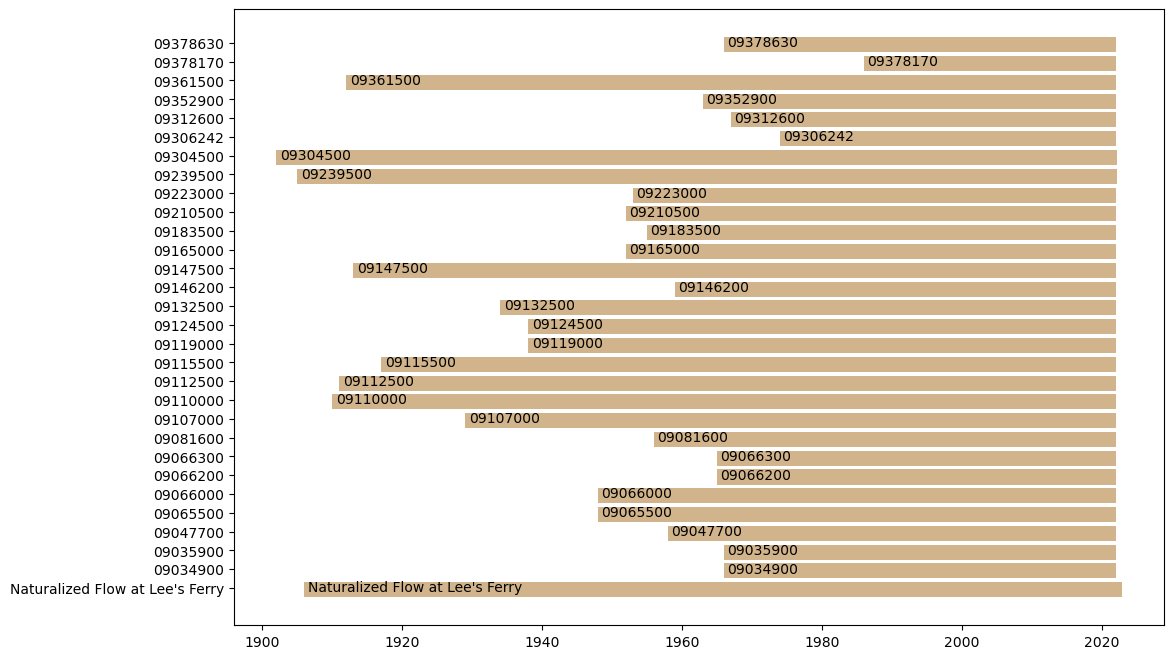

In [207]:
source = pd.DataFrame([{"data": "Naturalized Flow at Lee's Ferry","start": '1906-01-01', "end": '2022-09-30'},])
for i,site in enumerate(hcdn_q_spring_summer_mean_ds.site_no):
    min_year = int(hcdn_q_spring_summer_mean_ds.sel(site_no=site).WY.min().values)
    max_year = int(hcdn_q_spring_summer_mean_ds.sel(site_no=site).WY.max().values)
    source.loc[i+1] = {"data": str(site.values),"start": f'{min_year}-09-30', "end": f'{max_year}-10-01'}

source['start'] = pd.to_datetime(source['start'])
source['end'] = pd.to_datetime(source['end'])
source['diff'] = source['end'] - source['start']
 
# Declaring a figure "gnt"
fig, ax = plt.subplots(figsize=(12,8))
gnt=ax 
# Need to fix hidden tick labels
# https://stackoverflow.com/questions/43673659/matplotlib-not-showing-first-label-on-x-axis-for-the-bar-plot
 
y_tick_labels = source.data.values
y_pos = np.arange(len(y_tick_labels))
 
gnt.set_yticks(y_pos)
gnt.set_yticklabels(y_tick_labels)
 
 
# https://sparkbyexamples.com/python/iterate-over-rows-in-pandas-dataframe/
# https://www.tutorialspoint.com/plotting-dates-on-the-x-axis-with-python-s-matplotlib
# https://matplotlib.org/stable/gallery/color/named_colors.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
# https://www.geeksforgeeks.org/how-to-annotate-matplotlib-scatter-plots
for index, row in source.sort_values(by='start', ascending=True).iterrows():
    start_year = int(row.start.strftime("%Y"))
    duration = row['diff'].days/365
    gnt.broken_barh([(start_year, duration)], 
                    (index-0.5,0.8), 
                    facecolors =('tan'),
                   label=row.data)
    gnt.text(start_year+0.5, index-0.2, row.data)

Create a simple plot of basin-to-basin correlation of spring+summer mean streamflow

<AxesSubplot: xlabel='site_no', ylabel='site_no'>

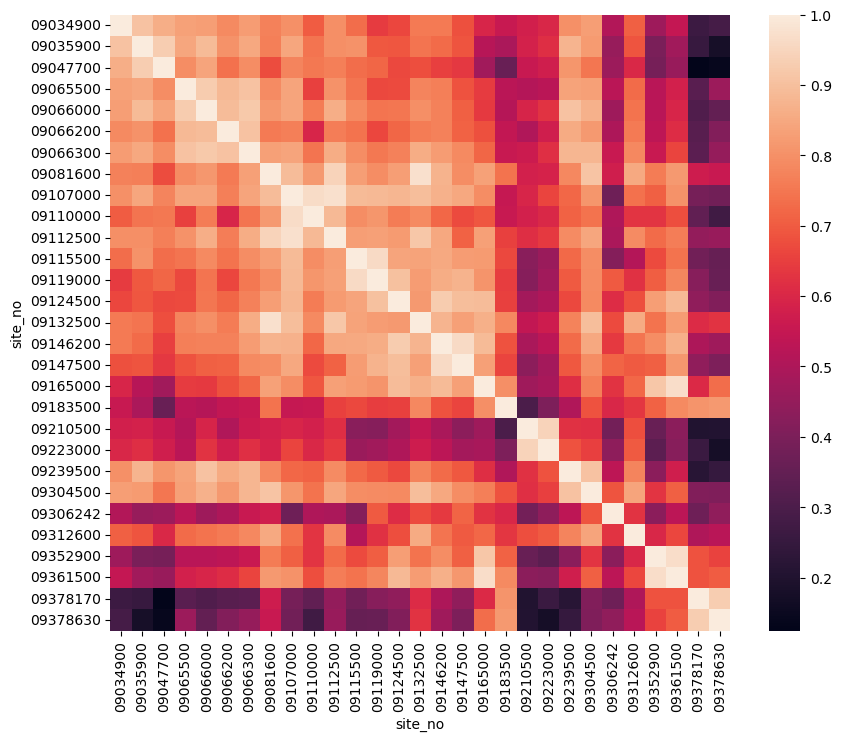

In [208]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(hcdn_q_spring_summer_mean_ds['00060_Mean'].to_pandas().corr(), ax=ax)

Plot basin mean elevation against mean $Q_{SpSu}$ 

Text(0.5, 1.0, 'Do North facing, high elevation, small basins have highest RR?')

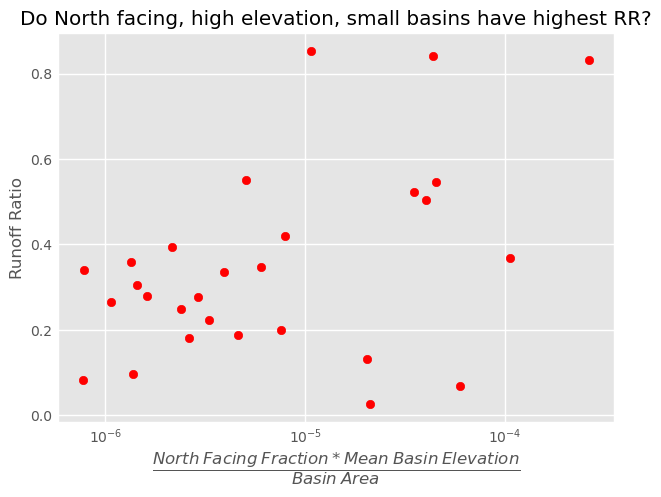

In [423]:
fig, ax = plt.subplots()
for site in hcdn_q_spring_summer_mean_ds.site_no:
    # ax.scatter(hcdn_q_spring_summer_mean_ds['north'].sel(site_no=site).max().values,
    #            hcdn_q_spring_summer_mean_ds['q_mm_day'].sel(site_no=site).mean().values,
    #            color='green',
    #            )
    ax.scatter(hcdn_q_spring_summer_mean_ds['north'].sel(site_no=site).max().values * hcdn_q_spring_summer_mean_ds['elevation'].sel(site_no=site).max().values/hcdn_q_spring_summer_mean_ds['basin_area'].sel(site_no=site).max().values,
               hcdn_q_spring_summer_mean_ds['q_mm_day'].sel(site_no=site).mean().values*365/2/hcdn_q_spring_summer_mean_ds['ppt'].sel(site_no=site).mean().values,
               color='red',
               )
# ax.scatter(ucrb_basin_boundary.area, (ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 / ucrb_basin_boundary.area.values[0] * 1000).mean())
ax.set_xscale('log')
ax.set_xlabel('$\dfrac{North\:Facing\:Fraction * Mean\:Basin\:Elevation}{Basin\:Area}$')
ax.set_ylabel('Runoff Ratio')
ax.set_title('Do North facing, high elevation, small basins have highest RR?')

Text(0.5, 1.0, 'Do high elevation basins have highest Q$_{SpSu}$?')

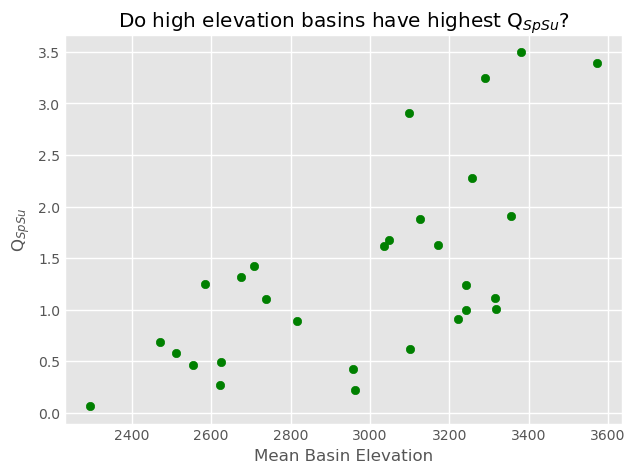

In [424]:
fig, ax = plt.subplots()
for site in hcdn_q_spring_summer_mean_ds.site_no:
    ax.scatter(hcdn_q_spring_summer_mean_ds['elevation'].sel(site_no=site).max().values,
               hcdn_q_spring_summer_mean_ds['q_mm_day'].sel(site_no=site).mean().values,
               color='green',
               )

ax.set_xlabel('Mean Basin Elevation')
ax.set_ylabel('Q$_{SpSu}$')
ax.set_title('Do high elevation basins have highest Q$_{SpSu}$?')

Trying k-means clustering to identify clusters

In [425]:
# Make a tidy dataframe for clustering
tidy_df = hcdn_q_spring_summer_mean_ds[['q_mm_day','elevation','basin_area']].mean(dim='year').to_dataframe().reset_index()
tidy_df['elevation_over_area'] = tidy_df['elevation']/tidy_df['basin_area']
q_elevation_array = tidy_df[['q_mm_day','elevation']].dropna().to_numpy()

In [372]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [373]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(q_elevation_array)

In [374]:
kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
        max_iter=300,
        random_state=42
    )

In [375]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [376]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

 # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

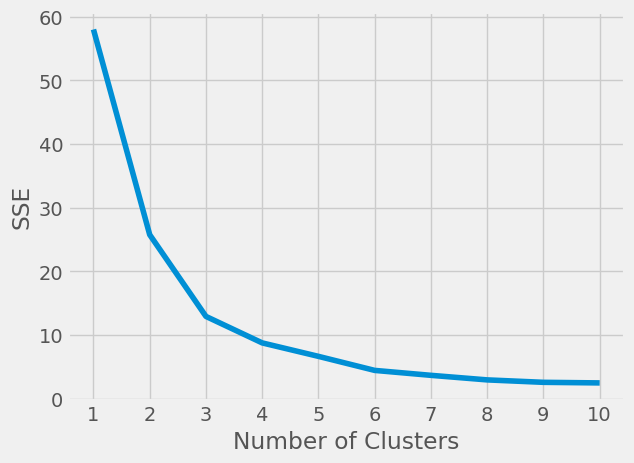

In [377]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [378]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
 )

kl.elbow

3

In [379]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

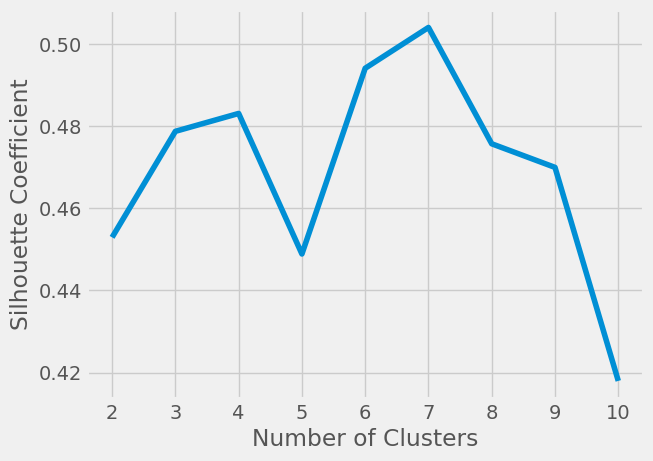

In [380]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [381]:
preprocessor = Pipeline(
     [
         ("scaler", MinMaxScaler()),
         ("pca", PCA(n_components=2, random_state=42)),
     ]
 )

In [382]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=3,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

The Pipeline class can be chained to form a larger pipeline. Build an end-to-end k-means clustering pipeline by passing the "preprocessor" and "clusterer" pipelines to Pipeline:

In [383]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [384]:
pipe.fit(scaled_features)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3, n_init=50,
                                         random_state=42))]))])

In [385]:
preprocessed_data = pipe["preprocessor"].transform(scaled_features)

predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.4741700287672549

In [386]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(scaled_features),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

In [387]:
tiday_clustered_df = tidy_df.dropna().reset_index(drop=True).merge(pcadf['predicted_cluster'], left_index=True,right_index=True)

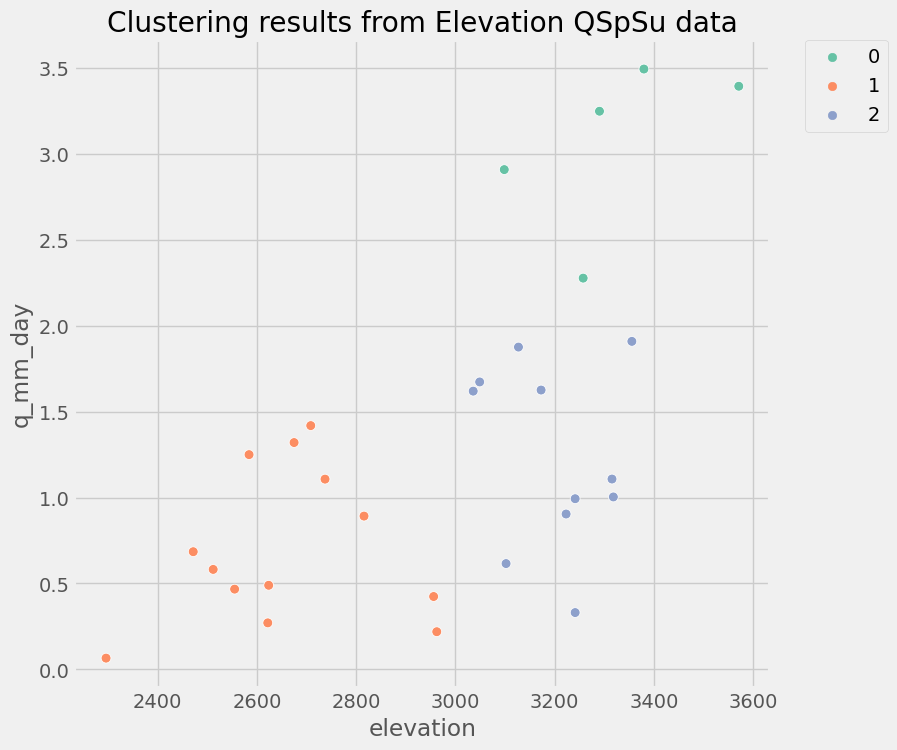

In [388]:
import seaborn as sns
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    data=tiday_clustered_df,
    x="elevation",
    y="q_mm_day",
    s=50,
    hue="predicted_cluster",
    palette="Set2",
)

scat.set_title(
    "Clustering results from Elevation QSpSu data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

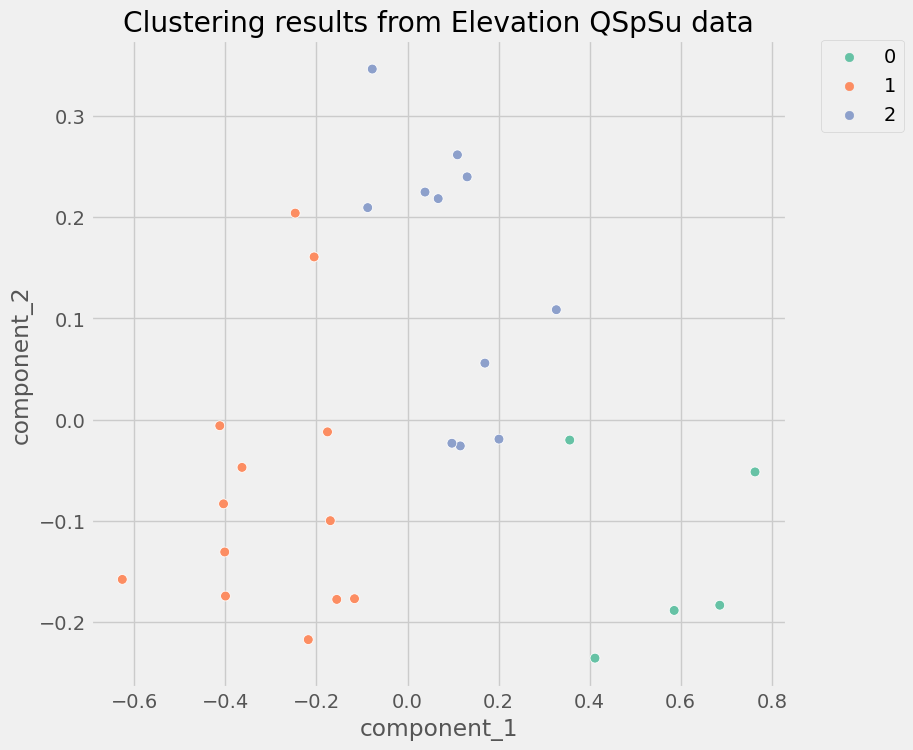

In [389]:
import seaborn as sns
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    data=pcadf,
    x="component_1",
    y="component_2",
    s=50,
    hue="predicted_cluster",
    palette="Set2",
)

scat.set_title(
    "Clustering results from Elevation QSpSu data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

# Plot winter and spring precipitation against naturalized streamflow

In [262]:
winter_spring_p = p_mean.where(p_mean.month.dt.month.isin([12,1,2,3,4,5])).groupby('WY').sum().sel(WY=slice(1906,2022))
winter_spring_p_stand_anom = (winter_spring_p-winter_spring_p.mean())/winter_spring_p.std()

winter_p = p_mean.where(p_mean.month.dt.month.isin([12,1,2])).groupby('WY').sum().sel(WY=slice(1906,2022))
winter_p_stand_anom = (winter_p-winter_p.mean())/winter_p.std()

spring_p = p_mean.where(p_mean.month.dt.month.isin([3,4,5])).groupby('WY').sum().sel(WY=slice(1906,2022))
spring_p_stand_anom = (spring_p-spring_p.mean())/spring_p.std()

summer_p = p_mean.where(p_mean.month.dt.month.isin([6,7,8])).groupby('WY').sum().sel(WY=slice(1906,2022))
summer_p_stand_anom = (summer_p-summer_p.mean())/summer_p.std()

In [263]:
drought_1930s = slice(1932,1936)
drought_1970s = slice(1976,1981)
drought_1980s = slice(1988,1993)
drought_2000s = slice(2000,2005)
drought_2010s = slice(2018,2022)

In [264]:
drought_years = [1932,1933,1934,1935,1936,
                1976,1977,1978,1979,1980,1981,
                1988,1989,1990,1991,1992,1993,
                2000,2001,2002,2003,2004,2005,
                2018,2019,2020,2021,2022]

In [265]:
def precipFlowLinReg(p, q, alternative='greater'):
    slope, intercept,r,_,_ = stats.linregress(p,q)
    return slope, intercept,r

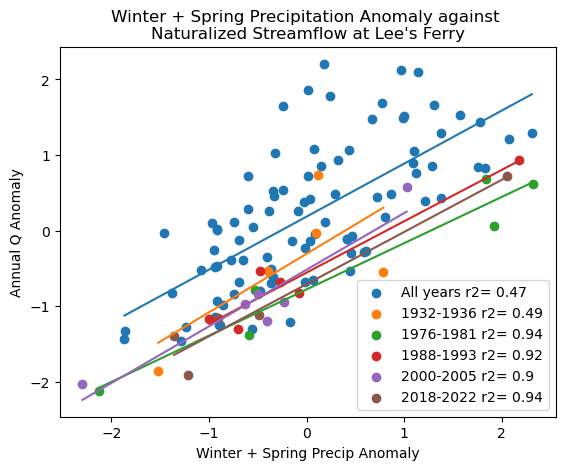

In [266]:
fig, ax = plt.subplots()
labels = ['1932-1936','1976-1981','1988-1993','2000-2005','2018-2022']

# Plot all points and trend-line
m,b,r = precipFlowLinReg(winter_spring_p_stand_anom.where(~winter_spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY'),
                          (ucrb_naturalized_streamflow[~ucrb_naturalized_streamflow.index.isin(drought_years)]['annual_flow_anom']))
x = [winter_spring_p_stand_anom.where(~winter_spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').min(),
     winter_spring_p_stand_anom.where(~winter_spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').max()]
y = [winter_spring_p_stand_anom.where(~winter_spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').min()*m+b,
     winter_spring_p_stand_anom.where(~winter_spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').max()*m+b]
ax.plot(x,y)
ax.scatter(winter_spring_p_stand_anom.where(~winter_spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY'), 
           (ucrb_naturalized_streamflow[~ucrb_naturalized_streamflow.index.isin(drought_years)]['annual_flow_anom']), label=f'All years r2= {round(r**2,2)}')

# Plot drought periods and trend lines
for i,drought in enumerate([drought_1930s,drought_1970s,drought_1980s,drought_2000s,drought_2010s]):
    m,b,r = precipFlowLinReg(winter_spring_p_stand_anom.sel(WY=drought)['ppt'], (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']))
    x = [winter_spring_p_stand_anom.sel(WY=drought)['ppt'].min(),winter_spring_p_stand_anom.sel(WY=drought)['ppt'].max()]
    y = [winter_spring_p_stand_anom.sel(WY=drought)['ppt'].min()*m+b,winter_spring_p_stand_anom.sel(WY=drought)['ppt'].max()*m+b]
    ax.plot(x,y)
    ax.scatter(winter_spring_p_stand_anom.sel(WY=drought)['ppt'], 
               (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']),
               label=f'{labels[i]} r2= {round(r**2,2)}')

ax.legend()
ax.set_xlabel('Winter + Spring Precip Anomaly')
ax.set_ylabel('Annual Q Anomaly')
ax.set_title("Winter + Spring Precipitation Anomaly against \nNaturalized Streamflow at Lee's Ferry")



ax.legend()

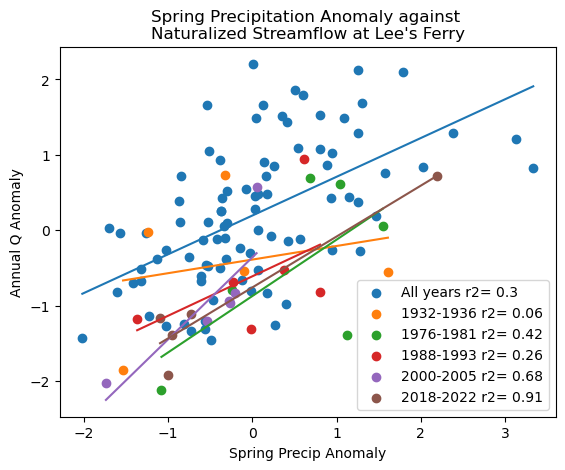

In [270]:
fig, ax = plt.subplots()
labels = ['1932-1936','1976-1981','1988-1993','2000-2005','2018-2022']


# Plot all points and trend-line
m,b,r = precipFlowLinReg(spring_p_stand_anom.where(~spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY'),
                          (ucrb_naturalized_streamflow[~ucrb_naturalized_streamflow.index.isin(drought_years)]['annual_flow_anom']))
x = [spring_p_stand_anom.where(~spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').min(),
     spring_p_stand_anom.where(~spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').max()]
y = [spring_p_stand_anom.where(~spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').min()*m+b,
     spring_p_stand_anom.where(~spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').max()*m+b]
ax.plot(x,y)
ax.scatter(spring_p_stand_anom.where(~spring_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY'), 
           (ucrb_naturalized_streamflow[~ucrb_naturalized_streamflow.index.isin(drought_years)]['annual_flow_anom']), label=f'All years r2= {round(r**2,2)}')
# ax.scatter(spring_p_stand_anom['ppt'], (ucrb_naturalized_streamflow['annual_flow_anom']), label=f'All years r2= {round(r**2,2)}')

# Plot drought periods and trend lines
for i,drought in enumerate([drought_1930s,drought_1970s,drought_1980s,drought_2000s,drought_2010s]):
    m,b,r = precipFlowLinReg(spring_p_stand_anom.sel(WY=drought)['ppt'], (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']))
    x = [spring_p_stand_anom.sel(WY=drought)['ppt'].min(),spring_p_stand_anom.sel(WY=drought)['ppt'].max()]
    y = [spring_p_stand_anom.sel(WY=drought)['ppt'].min()*m+b,spring_p_stand_anom.sel(WY=drought)['ppt'].max()*m+b]
    ax.plot(x,y)
    ax.scatter(spring_p_stand_anom.sel(WY=drought)['ppt'], 
               (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']),
               label=f'{labels[i]} r2= {round(r**2,2)}')

ax.legend()
ax.set_xlabel('Spring Precip Anomaly')
ax.set_ylabel('Annual Q Anomaly')
ax.set_title("Spring Precipitation Anomaly against \nNaturalized Streamflow at Lee's Ferry")



ax.legend()

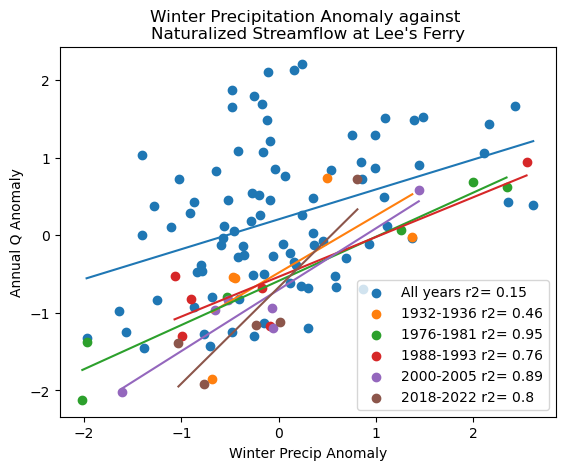

In [269]:
fig, ax = plt.subplots()
labels = ['1932-1936','1976-1981','1988-1993','2000-2005','2018-2022']

# Plot all points and trend-line
m,b,r = precipFlowLinReg(winter_p_stand_anom.where(~winter_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY'),
                          (ucrb_naturalized_streamflow[~ucrb_naturalized_streamflow.index.isin(drought_years)]['annual_flow_anom']))
x = [winter_p_stand_anom.where(~winter_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').min(),
     winter_p_stand_anom.where(~winter_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').max()]
y = [winter_p_stand_anom.where(~winter_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').min()*m+b,
     winter_p_stand_anom.where(~winter_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY').max()*m+b]
ax.plot(x,y)
ax.scatter(winter_p_stand_anom.where(~winter_p_stand_anom.WY.isin(drought_years))['ppt'].dropna(dim='WY'), 
           (ucrb_naturalized_streamflow[~ucrb_naturalized_streamflow.index.isin(drought_years)]['annual_flow_anom']), label=f'All years r2= {round(r**2,2)}')
# Plot drought periods and trend lines
for i,drought in enumerate([drought_1930s,drought_1970s,drought_1980s,drought_2000s,drought_2010s]):
    m,b,r = precipFlowLinReg(winter_p_stand_anom.sel(WY=drought)['ppt'], (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']))
    x = [winter_p_stand_anom.sel(WY=drought)['ppt'].min(),winter_p_stand_anom.sel(WY=drought)['ppt'].max()]
    y = [winter_p_stand_anom.sel(WY=drought)['ppt'].min()*m+b,winter_p_stand_anom.sel(WY=drought)['ppt'].max()*m+b]
    ax.plot(x,y)
    ax.scatter(winter_p_stand_anom.sel(WY=drought)['ppt'], 
               (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']),
               label=f'{labels[i]} r2= {round(r**2,2)}')

ax.legend()
ax.set_xlabel('Winter Precip Anomaly')
ax.set_ylabel('Annual Q Anomaly')
ax.set_title("Winter Precipitation Anomaly against \nNaturalized Streamflow at Lee's Ferry")



ax.legend()

Interesting to note the change in slope in the more recent dry periods. It is significantly steeper. Now want to replicate this in other basins?

In [271]:
rolling_windows = np.arange(1,21,1)
rolling_vals = {}
min_start_year = []
for window in rolling_windows:
    rolling_vals[window] = ucrb_naturalized_streamflow['annual_flow_km3'].rolling(window, center=False).mean()
    min_start_year.append(rolling_vals[window].idxmin() - window)

(3.0, 30.0)

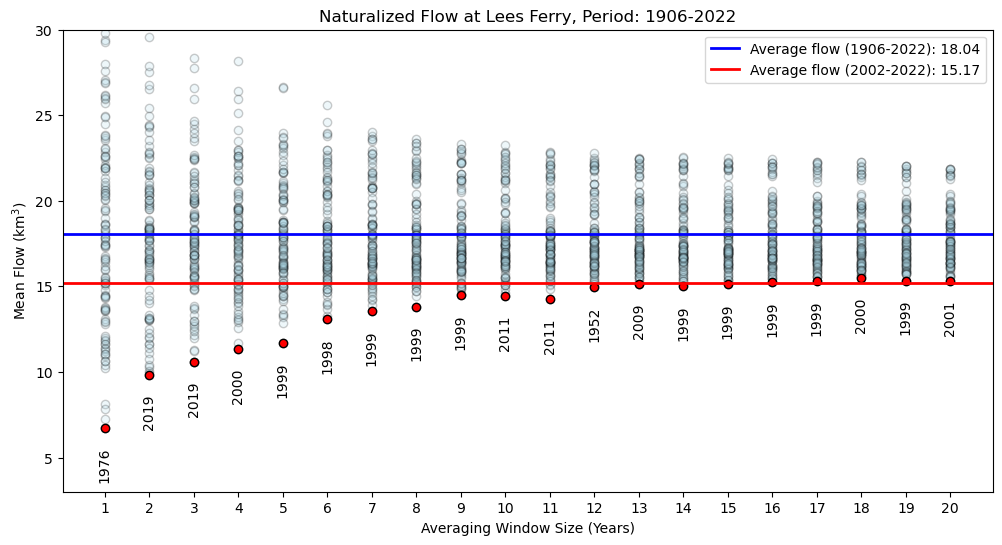

In [272]:
rolling_q_df = pd.DataFrame(rolling_vals)
plt.figure(figsize=(12,6))
for i,col in enumerate(rolling_q_df):
    plt.scatter(np.full(len(rolling_q_df.index),col), rolling_q_df[col], color='lightblue', alpha=0.2, ec='k')
    plt.scatter(col, rolling_q_df.loc[min_start_year[i]+col,col], color='red', ec='k')
    plt.text(x=col, 
            y=rolling_q_df.loc[min_start_year[i]+col,col]-3, 
            s=min_start_year[i],
            rotation='vertical',
            horizontalalignment='center')
plt.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='blue',lw=2,
            label=f"Average flow (1906-2022): {round(ucrb_naturalized_streamflow['annual_flow_km3'].mean(),2)}")
plt.axhline(ucrb_naturalized_streamflow.loc[2002:2022,'annual_flow_km3'].mean(), color='red',lw=2,
            label=f"Average flow (2002-2022): {round(ucrb_naturalized_streamflow.loc[2002:2022,'annual_flow_km3'].mean(),2)}")
plt.title('Naturalized Flow at Lees Ferry, Period: 1906-2022')
plt.ylabel('Mean Flow (km$^3$)')
plt.xlabel('Averaging Window Size (Years)')
plt.legend()
plt.xticks(rolling_windows);
plt.ylim(3,30)

In [273]:
def cumulativeDeparture(df):
    return (ucrb_naturalized_streamflow['annual_flow_km3'].mean() - df).sum()


In [274]:
rolling_windows_sum = np.arange(1,21,1)
rolling_vals_sum = {}
max_start_year_sum = []
for window in rolling_windows:
    rolling_vals_sum[window] = ucrb_naturalized_streamflow['annual_flow_km3'].rolling(window, center=False).apply(lambda x: cumulativeDeparture(x))
    max_start_year_sum.append(rolling_vals_sum[window].idxmax() - window)

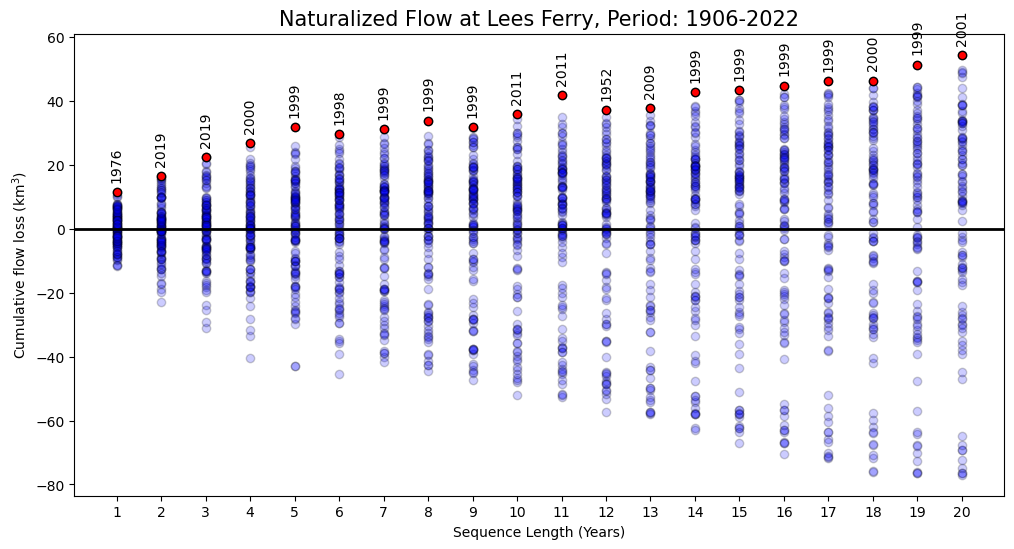

In [275]:
rolling_q_sum_df = pd.DataFrame(rolling_vals_sum)
plt.figure(figsize=(12,6))
plt.axhline(0, color='k',lw=2)
for i,col in enumerate(rolling_q_sum_df):
    plt.scatter(np.full(len(rolling_q_sum_df.index),col), rolling_q_sum_df[col], color='blue', alpha=0.2, ec='k')
    plt.scatter(col, rolling_q_sum_df.loc[max_start_year_sum[i]+col,col], color='red', ec='k')
    plt.text(x=col, 
             y=rolling_q_sum_df.loc[max_start_year_sum[i]+col,col]+4, 
             s=max_start_year_sum[i],
             rotation='vertical',
             horizontalalignment='center')
plt.title('Naturalized Flow at Lees Ferry, Period: 1906-2022', size=15)
plt.ylabel('Cumulative flow loss (km$^3$)')
plt.xlabel('Sequence Length (Years)')
plt.xticks(rolling_windows_sum);

# Working on mimicing the plots from Biederman et all.

In [402]:
hcdn_prism_winter_ppt = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month==12)
hcdn_prism_winter_ppt = hcdn_prism_winter_ppt.groupby(hcdn_prism_winter_ppt.month.dt.year).mean()
hcdn_prism_winter_ppt = hcdn_prism_winter_ppt.rename({'ppt':'winter_ppt'})
hcdn_prism_winter_ppt = hcdn_prism_winter_ppt.where(hcdn_prism_winter_ppt>0)

hcdn_prism_spring_ppt = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month==3)
hcdn_prism_spring_ppt = hcdn_prism_spring_ppt.groupby(hcdn_prism_spring_ppt.month.dt.year).mean()
hcdn_prism_spring_ppt = hcdn_prism_spring_ppt.rename({'ppt':'spring_ppt'})

hcdn_prism_wisp_ppt = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month.isin([12,3]))
hcdn_prism_wisp_ppt = hcdn_prism_wisp_ppt.groupby(hcdn_prism_wisp_ppt.month.dt.year).mean()*2
hcdn_prism_wisp_ppt = hcdn_prism_wisp_ppt.rename({'ppt':'wisp_ppt'})

hcdn_prism_summer_ppt = hcdn_prism_seasonal_ppt.where(hcdn_prism_seasonal_ppt.month.dt.month.isin([9]))
hcdn_prism_summer_ppt = hcdn_prism_summer_ppt.groupby(hcdn_prism_summer_ppt.month.dt.year).mean()
hcdn_prism_summer_ppt = hcdn_prism_summer_ppt.rename({'ppt':'summer_ppt'})

In [403]:
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_winter_ppt)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_spring_ppt)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_wisp_ppt)
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_mean_ds.merge(hcdn_prism_summer_ppt)

Text(-0.02, 0.5, 'Q$_{SpSu}$ [mm]')

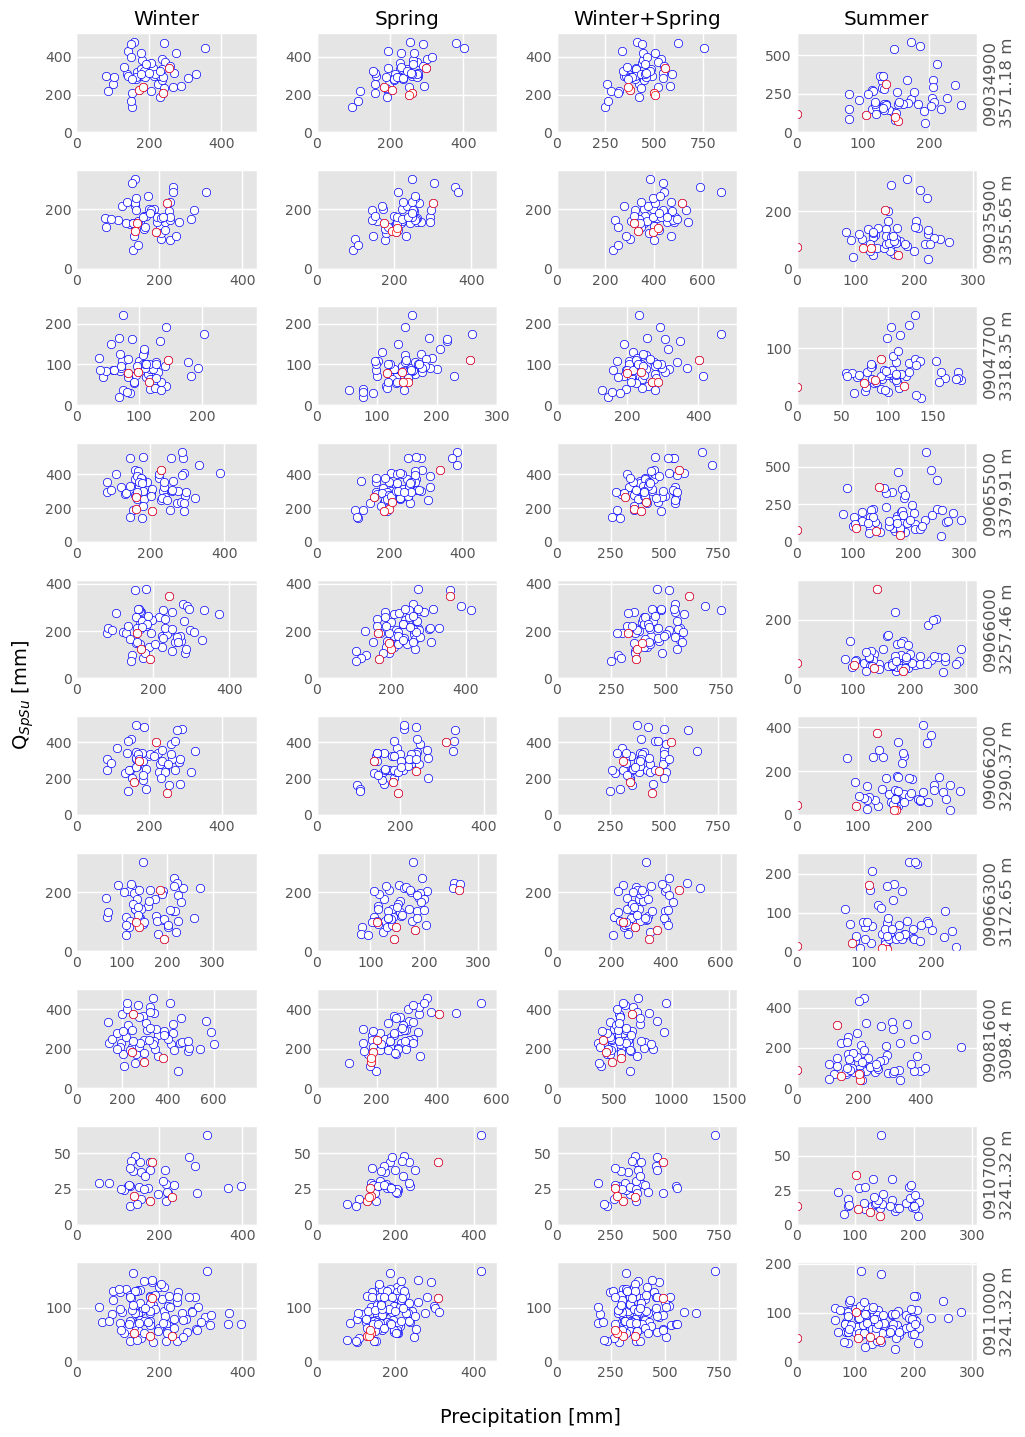

In [404]:
plt.style.use("ggplot")
fig, axs = plt.subplots(10,4, figsize=(10,14), tight_layout=True)
for i,site_no in enumerate(hcdn_q_spring_summer_mean_ds.site_no.values[0:10]):
    mean_elev = round(float(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no).elevation.max().values),2)
    ax = axs[i,0]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['winter_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no, year=drought_2010s)['winter_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no, year=drought_2010s)['q_mm_day']*30.425*3,
            color='white',
            ec='red')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['winter_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,1]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['spring_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no, year=drought_2010s)['spring_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no, year=drought_2010s)['q_mm_day']*30.425*3,
            color='white',
            ec='red')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['spring_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,2]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['wisp_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3,
            color='white',
            ec='blue')
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no, year=drought_2010s)['wisp_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no, year=drought_2010s)['q_mm_day']*30.425*3,
            color='white',
            ec='red')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['wisp_ppt'].max()*1.1)
    ax.set_ylim(0,1.1*(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day']*30.425*3).max())

    ax = axs[i,3]
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['summer_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day_summer']*30.425*3,
            color='white',
            ec='blue')
    ax.scatter(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no, year=drought_2010s)['summer_ppt'],
            hcdn_q_spring_summer_mean_ds.sel(site_no=site_no, year=drought_2010s)['q_mm_day_summer']*30.425*3,
            color='white',
            ec='red')
    ax.set_xlim(0,hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['summer_ppt'].max()*1.1)
    ax.set_ylim(0,(hcdn_q_spring_summer_mean_ds.sel(site_no=site_no)['q_mm_day_summer']*30.425*3).max()*1.1)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"{site_no}\n{mean_elev} m")
axs[0,0].set_title('Winter')
axs[0,1].set_title('Spring')
axs[0,2].set_title('Winter+Spring')
axs[0,3].set_title('Summer')

fig.text(0.5, -0.02, 'Precipitation [mm]', ha='center', size=14)
fig.text(-0.02, 0.5, 'Q$_{SpSu}$ [mm]', va='center', rotation='vertical', size=14)

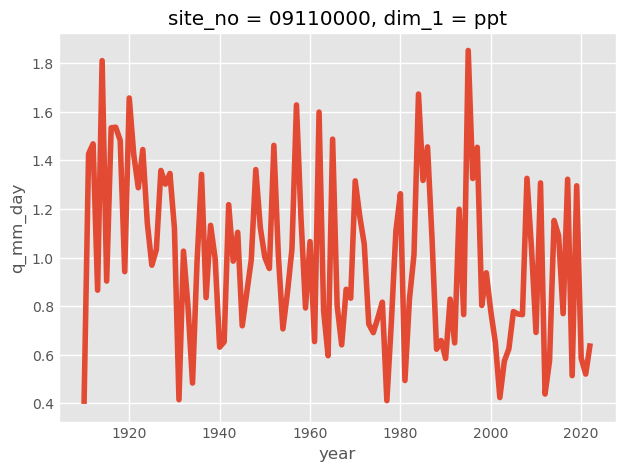

In [410]:
hcdn_q_spring_summer_mean_ds.sel(site_no='09110000')['q_mm_day'].plot()

In [412]:
hcdn_q_spring_summer_mean_ds.sel(site_no='09107000').basin_area

<xarray.DataArray 'basin_area' (year: 129)>
array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan, 1.23690438e+09,
       1.23690438e+09, 1.23690438e+09, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09, 1.23690438e+09, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09, 1.23690438e+09, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09, 1.23690438e+09, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09, 1.23690438e+09, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09, 1.23690438e+09, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09, 1.23690438e+09, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09, 1.23690438e+09, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09, 1.23690438e+09, 1.23690438e+09, 1.23690438e+09,
       1.23690438e+09])
Coordinates:
    site_no  <U8 '09107000'
  * year     (year) int64 1894 1895 1896 1897 1898 ... 2018 2019 2020 2021 2022
    dim_1    <U3 'ppt'